- https://arxiv.org/abs/2309.17453

In [2]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from typing import List, Tuple

In [14]:
def get_attention_maps(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer, 
    text: str,
    layer_nums: List[int] = [0, 1, 2, 9, 16, 23, 31]
) -> Tuple[torch.Tensor, List[str]]:
    """获取指定层的 attention maps"""
    
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt")
    
    # Get attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    attentions = outputs.attentions
    print(len(attentions), attentions[0].shape)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    
    # 选择指定层的 attention maps
    selected_attentions = [attentions[i] for i in layer_nums]
    
    # 平均所有 attention heads
    avg_attentions = [attn.mean(dim=1).squeeze(0) for attn in selected_attentions]
    
    return avg_attentions, tokens

def plot_attention_maps(
    attention_maps: List[torch.Tensor],
    tokens: List[str],
    layer_nums: List[int]
) -> None:
    """绘制 attention maps"""
    
    n_layers = len(attention_maps)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for idx, (attn, layer_num) in enumerate(zip(attention_maps, layer_nums)):
        if idx == 0:
            np.set_printoptions(precision=2)
            print(attn.numpy())
        im = axes[idx].imshow(attn.numpy(), cmap='RdBu')
        axes[idx].set_title(f'Layer {layer_num} Head 0')
        axes[idx].set_xticks(range(len(tokens)))
        axes[idx].set_yticks(range(len(tokens)))
        plt.colorbar(im, ax=axes[idx])
    
    plt.tight_layout()
    # plt.savefig('llama3_attention_maps.png')
    # plt.close()

In [4]:
model_name = "meta-llama/Meta-Llama-3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    attn_implementation="eager"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

We've detected an older driver with an RTX 4000 series GPU. These drivers have issues with P2P. This can affect the multi-gpu inference when using accelerate device_map.Please make sure to update your driver to the latest version which resolves this.


In [16]:
model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Meta-Llama-3-8B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 500000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.45.0.dev0",
  "use_cache": true,
  "vocab_size": 128256
}

In [15]:
# 准备输入文本
text = "The quick brown fox jumps over the lazy dog."

# 获取 attention maps
attention_maps, tokens = get_attention_maps(model, tokenizer, text)


32 torch.Size([1, 32, 11, 11])


In [9]:
tokens

['<|begin_of_text|>',
 'The',
 'Ġquick',
 'Ġbrown',
 'Ġfox',
 'Ġjumps',
 'Ġover',
 'Ġthe',
 'Ġlazy',
 'Ġdog',
 '.']

[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.88 0.12 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.82 0.14 0.04 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.8  0.1  0.06 0.04 0.   0.   0.   0.   0.   0.   0.  ]
 [0.78 0.09 0.02 0.07 0.04 0.   0.   0.   0.   0.   0.  ]
 [0.75 0.07 0.02 0.04 0.09 0.03 0.   0.   0.   0.   0.  ]
 [0.76 0.06 0.02 0.02 0.03 0.07 0.04 0.   0.   0.   0.  ]
 [0.66 0.05 0.01 0.01 0.02 0.03 0.08 0.14 0.   0.   0.  ]
 [0.7  0.04 0.01 0.02 0.02 0.02 0.03 0.12 0.03 0.   0.  ]
 [0.7  0.04 0.01 0.01 0.03 0.02 0.01 0.1  0.05 0.03 0.  ]
 [0.6  0.05 0.02 0.02 0.02 0.02 0.01 0.05 0.02 0.03 0.15]]


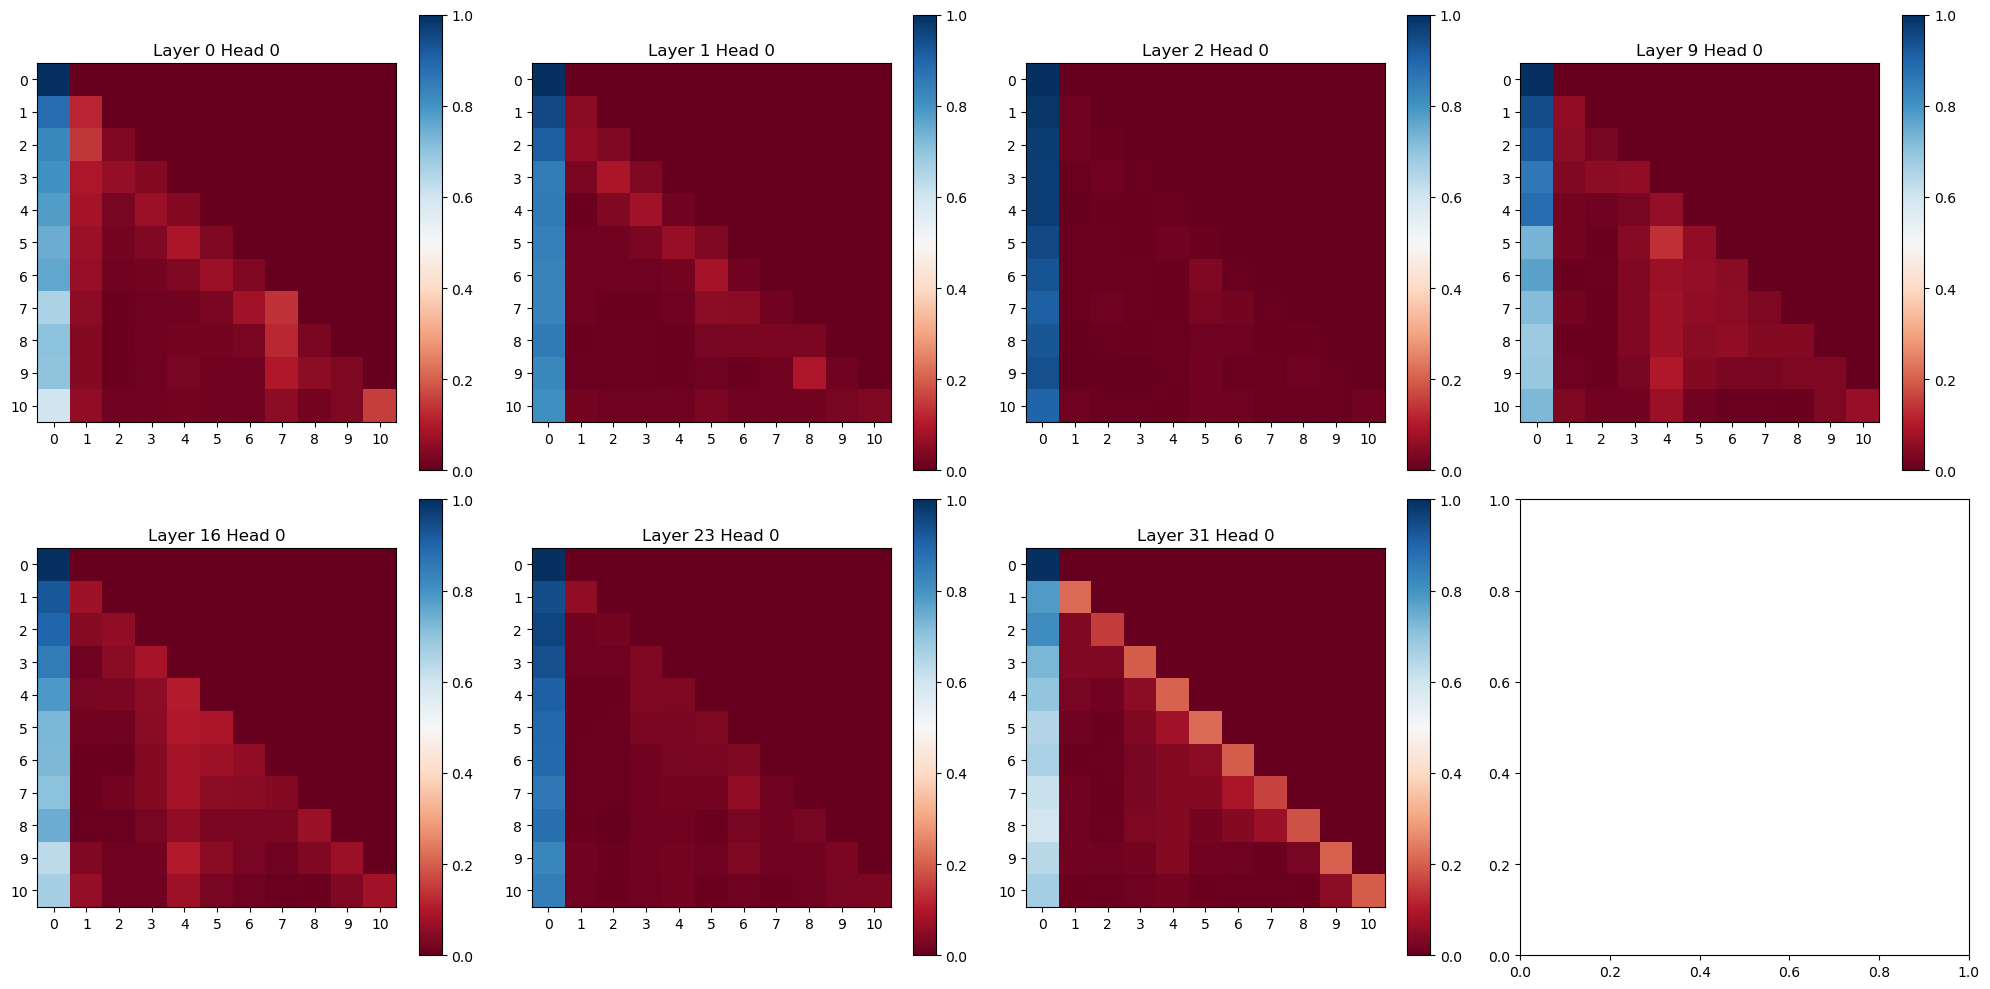

In [13]:
# 绘制可视化图
plot_attention_maps(attention_maps, tokens, [0, 1, 2, 9, 16, 23, 31])